In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The GE dataset

In [2]:
buy_average = pd.read_csv("data/rsbuddy/buy_average.csv")
buy_average = buy_average.set_index('timestamp')

In [3]:
buy_average.head()

,Cannonball,Cannon_base,Cannon_stand,Cannon_barrels,Cannon_furnace,Insect_repellent,Bucket_of_wax,Candle,Bronze_arrowtips,Iron_arrowtips,...,Watchtower_teleport,Teleport_to_house,Bones_to_bananas,Bones_to_peaches,Enchant_sapphire_or_opal,Enchant_emerald_or_jade,Enchant_ruby_or_topaz,Enchant_diamond,Enchant_dragonstone,Enchant_onyx
timestamp,,,,,,,,,,,,,,,,,,,,,
1577227800,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228101,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228400,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228700,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577229001,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0


In [4]:
buy_average.shape

(3398, 3657)

In [5]:
buy_average = buy_average.drop_duplicates()

In [6]:
buy_average.shape

(1086, 3657)

In [7]:
item_to_predict = 'Rune_axe'
items_selected = ['Rune_axe', 'Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']
df = buy_average[items_selected].replace(to_replace=0, method='ffill')
print(df.shape)
df.head()

(1086, 6)


,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield
timestamp,,,,,,
1577227800,7196,37882,15022,29748,20602,32079
1577229600,7123,37881,15036,29657,20600,32095
1577231400,7237,37821,15019,29577,20633,32340
1577233501,7250,37816,15018,29530,20634,32152
1577235300,7316,37819,15009,29743,20785,32119


# Feature Engineering

## Known finance features (MACD, RSI)

In [8]:
def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = group.ewm(span=nslow, min_periods=1).mean()
    emafast = group.ewm(span=nfast, min_periods=1).mean()
    result = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    return result

def moving_average(group, n=9):
    sma = group.rolling(n).mean()
    sma=sma.rename('SMA')
    return sma

def RSI(group, n=14):
    delta = group.diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n).mean()
    RolDown = dDown.rolling(n).mean().abs()
    
    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    rsi=rsi.rename('RSI')
    return rsi

In [9]:
macd = moving_average_convergence(df[item_to_predict])
sma = moving_average(df[item_to_predict])
rsi = RSI(df[item_to_predict], 10)
finance_features = pd.concat([macd, sma, rsi], axis=1)
finance_features.head()

,MACD,emaSlw,emaFst,SMA,RSI
timestamp,,,,,
1577227800,0.000000,7196.000000,7196.000000,NaN,NaN
1577229600,-1.637821,7158.096154,7156.458333,NaN,NaN
1577231400,1.448225,7186.445540,7187.893764,NaN,NaN
1577233501,3.285686,7204.212589,7207.498276,NaN,NaN
1577235300,6.841255,7230.136551,7236.977807,NaN,NaN


## Fetched API features (buy quantity, sell price average)

In [10]:
sell_average = pd.read_csv("data/rsbuddy/sell_average.csv")
sell_average = sell_average.set_index('timestamp')
sell_average = sell_average.drop_duplicates()
sell_average = sell_average[items_selected].replace(to_replace=0, method='ffill')
print(sell_average.shape)
sell_average.columns = [str(col) + '_sa' for col in sell_average.columns]
sell_average.head()

(1086, 6)


,Rune_axe_sa,Rune_2h_sword_sa,Rune_scimitar_sa,Rune_chainbody_sa,Rune_full_helm_sa,Rune_kiteshield_sa
timestamp,,,,,,
1577227800,7178,37818,14979,29506,20590,32059
1577229600,7147,37848,14982,29507,20595,32052
1577231400,7150,37828,14988,29498,20597,32053
1577233501,7160,37795,14991,29448,20600,32058
1577235300,7191,37808,14995,29430,20596,32061


In [11]:
buy_quantity = pd.read_csv("data/rsbuddy/buy_quantity.csv")
buy_quantity = buy_quantity.set_index('timestamp')
buy_quantity = buy_quantity.drop_duplicates()
buy_quantity = buy_quantity[items_selected].replace(to_replace=0, method='ffill')
print(buy_quantity.shape)
buy_quantity.columns = [str(col) + '_bq' for col in buy_quantity.columns]
buy_quantity.head()

(1086, 6)


,Rune_axe_bq,Rune_2h_sword_bq,Rune_scimitar_bq,Rune_chainbody_bq,Rune_full_helm_bq,Rune_kiteshield_bq
timestamp,,,,,,
1577227800,85,234,62,1,256,220
1577229600,26,170,40,22,202,159
1577231400,4,76,55,53,75,23
1577233501,2,201,57,33,32,86
1577235300,5,241,13,29,3,91


In [12]:
sell_quantity = pd.read_csv("data/rsbuddy/sell_quantity.csv")
sell_quantity = sell_quantity.set_index('timestamp')
sell_quantity = sell_quantity.drop_duplicates()
sell_quantity = sell_quantity[items_selected].replace(to_replace=0, method='ffill')
print(sell_quantity.shape)
sell_quantity.columns = [str(col) + '_sq' for col in sell_quantity.columns]
sell_quantity.head()

(1086, 6)


,Rune_axe_sq,Rune_2h_sword_sq,Rune_scimitar_sq,Rune_chainbody_sq,Rune_full_helm_sq,Rune_kiteshield_sq
timestamp,,,,,,
1577227800,38,33,56,56,145,167
1577229600,23,23,68,59,171,112
1577231400,47,26,136,57,165,70
1577233501,47,23,151,61,89,78
1577235300,15,17,47,37,138,122


## Datetime properties

In [13]:
df['datetime'] = df.index
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df.head()

,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield,datetime,dayofweek,hour
timestamp,,,,,,,,,
1577227800,7196,37882,15022,29748,20602,32079,2019-12-24 22:50:00,1,22
1577229600,7123,37881,15036,29657,20600,32095,2019-12-24 23:20:00,1,23
1577231400,7237,37821,15019,29577,20633,32340,2019-12-24 23:50:00,1,23
1577233501,7250,37816,15018,29530,20634,32152,2019-12-25 00:25:01,2,0
1577235300,7316,37819,15009,29743,20785,32119,2019-12-25 00:55:00,2,0


## Appending features to main dataframe

In [14]:
df = pd.concat([df,finance_features, sell_average, buy_quantity, sell_quantity], axis=1)
df = df.dropna()
print(df.shape)
df.head()

(1076, 32)


,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield,datetime,dayofweek,hour,MACD,...,Rune_scimitar_bq,Rune_chainbody_bq,Rune_full_helm_bq,Rune_kiteshield_bq,Rune_axe_sq,Rune_2h_sword_sq,Rune_scimitar_sq,Rune_chainbody_sq,Rune_full_helm_sq,Rune_kiteshield_sq
timestamp,,,,,,,,,,,,,,,,,,,,,
1577246100,7165,37849,14984,29747,20687,32350,2019-12-25 03:55:00,2,3,-1.996887,...,177,1,2,1,71,16,40,20,113,122
1577247901,7169,37830,15050,29747,20687,32046,2019-12-25 04:25:01,2,4,-4.668313,...,42,1,2,112,68,15,37,13,136,123
1577249700,7163,37875,15048,29747,20798,32047,2019-12-25 04:55:00,2,4,-6.926516,...,36,1,11,202,52,18,42,12,136,68
1577251500,7194,37915,14956,29747,20798,32090,2019-12-25 05:25:00,2,5,-6.730209,...,69,1,11,155,52,315,29,14,122,96
1577253301,7186,37907,14983,29420,20573,32131,2019-12-25 05:55:01,2,5,-6.971026,...,162,1,355,86,519,308,19,548,1702,120


# Time Series Analysis

In [15]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [16]:
TRAIN_SPLIT = 750

In [17]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [18]:
uni_data = df[item_to_predict]
uni_data.head()

timestamp
1577246100    7165
1577247901    7169
1577249700    7163
1577251500    7194
1577253301    7186
Name: Rune_axe, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1AF9E5438>],
      dtype=object)

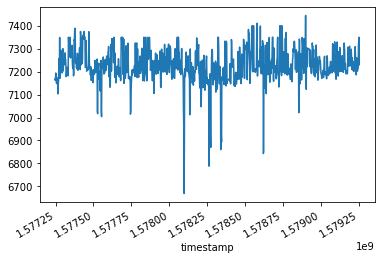

In [19]:
uni_data.plot(subplots=True)

In [20]:
uni_data = uni_data.values

In [21]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [22]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [23]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [24]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.68824541]
 [-0.63801097]
 [-0.71336264]
 [-0.32404567]
 [-0.42451457]
 [-0.82639014]
 [-0.90174181]
 [-0.90174181]
 [-0.58777652]
 [-0.7761557 ]
 [-0.90174181]
 [-1.46687934]
 [-0.90174181]
 [-0.75103847]
 [ 0.45458826]
 [ 0.2913263 ]
 [-0.21101817]
 [ 1.62253915]
 [-0.61289374]
 [-0.52498346]
 [-0.33660429]
 [ 0.91925689]
 [-0.09799066]
 [-0.1356665 ]
 [-0.09799066]
 [-0.11054927]
 [-0.31148706]
 [ 0.89413967]
 [ 0.89413967]
 [ 1.00716717]]

 Target to predict
-0.21101816734611953


In [25]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [26]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

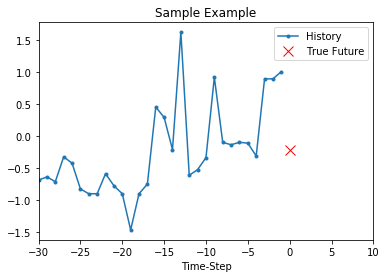

In [27]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

### Baseline


In [28]:
def baseline(history):
  return np.mean(history)

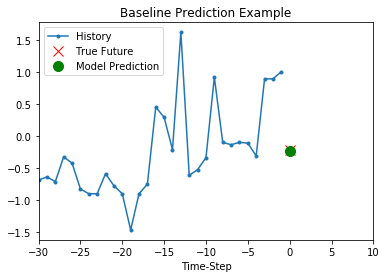

In [29]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [30]:
BATCH_SIZE = 32
BUFFER_SIZE = 30

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [31]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [32]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(32, 1)


In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 33ms/step - loss: 0.6605 - val_loss: 0.5495
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.6299 - val_loss: 0.5315
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5959 - val_loss: 0.5026
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5587 - val_loss: 0.4765
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5390 - val_loss: 0.4713
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5436 - val_loss: 0.4726
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5370 - val_loss: 0.4718
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5347 - val_loss: 0.4698
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5333 - val_loss: 0.4706
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model


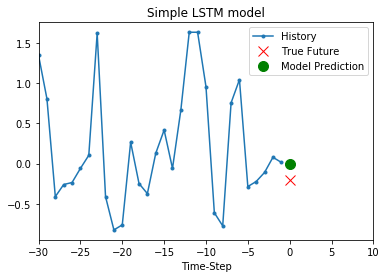

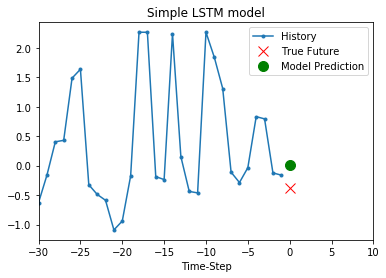

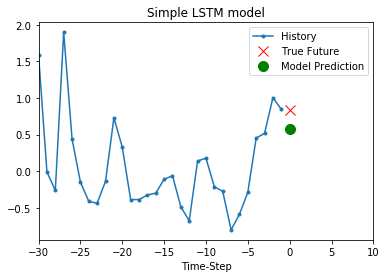

In [34]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Multivariate time series

In [35]:
features_considered = ['dayofweek', item_to_predict, 'MACD', 'RSI', 'SMA'] 
# ['MACD', 'RSI', 'SMA', 'Rune_axe', 'Rune_axe_bq', 'Rune_axe_sq', 'Rune_axe_sa', 'hour', 'dayofweek',
# Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']

In [36]:
features = df[features_considered]
# features.index = df['timestamp']
features.head()

,dayofweek,Rune_axe,MACD,RSI,SMA
timestamp,,,,,
1577246100,2,7165,-1.996887,47.495961,7238.111111
1577247901,2,7169,-4.668313,54.181818,7230.555556
1577249700,2,7163,-6.926516,41.628959,7220.888889
1577251500,2,7194,-6.730209,43.913043,7207.333333
1577253301,2,7186,-6.971026,33.830846,7204.555556


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1BDA5E3C8>,
      dtype=object)

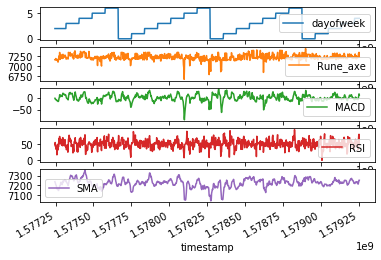

In [37]:
features.plot(subplots=True)

In [38]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [39]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [41]:
past_history = 30
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 5)


In [43]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [44]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [45]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(32, 1)


In [46]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 0.6685 - val_loss: 0.6151
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6437 - val_loss: 0.6173
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6310 - val_loss: 0.6367
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6098 - val_loss: 0.6241
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5987 - val_loss: 0.6439
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5839 - val_loss: 0.6661
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5575 - val_loss: 0.6730
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5393 - val_loss: 0.7262
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5197 - val_loss: 0.7529
Epoch 10/10
200/200 [===========================

In [47]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

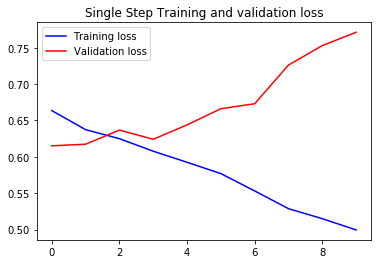

In [48]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

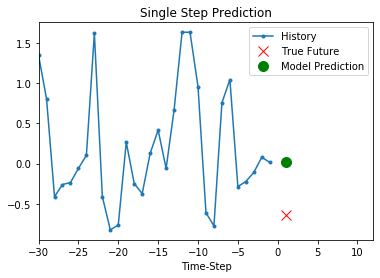

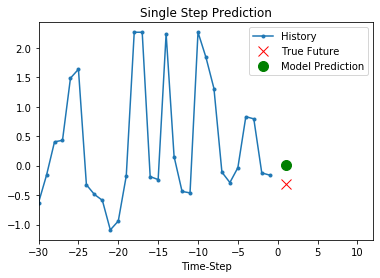

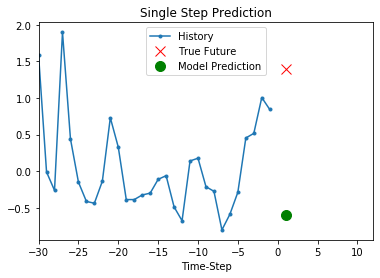

In [49]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [50]:
future_target = 10
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [51]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (30, 5)

 Target temperature to predict : (10,)


In [52]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [53]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

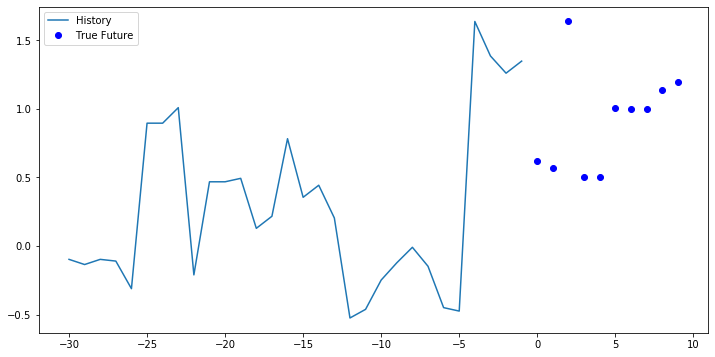

In [54]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [55]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [56]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(32, 10)


In [57]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 12s 59ms/step - loss: 0.6859 - val_loss: 0.5817
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6571 - val_loss: 0.6114
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6331 - val_loss: 0.6472
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 0.6116 - val_loss: 0.6553
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.5977 - val_loss: 0.6568
Epoch 6/10
200/200 [==============================] - 6s 28ms/step - loss: 0.5890 - val_loss: 0.6491
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.5734 - val_loss: 0.6619
Epoch 8/10
200/200 [==============================] - 5s 27ms/step - loss: 0.5618 - val_loss: 0.6494
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.5563 - val_loss: 0.6409
Epoch 10/10
200/200 [==========================

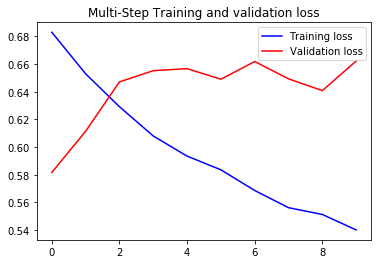

In [58]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

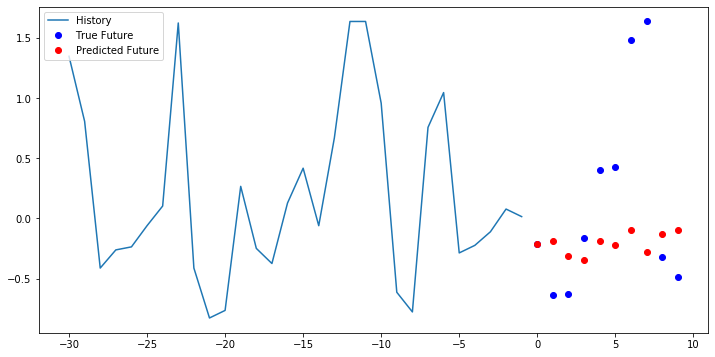

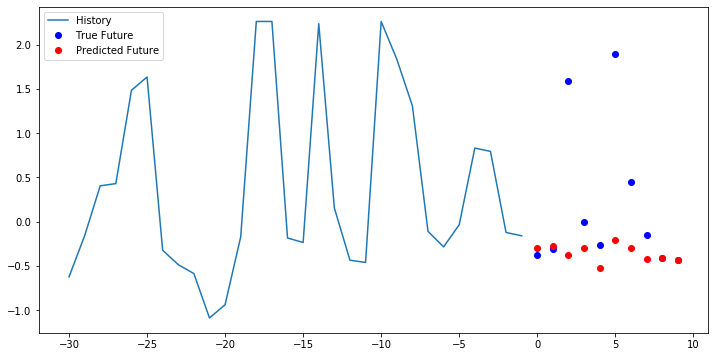

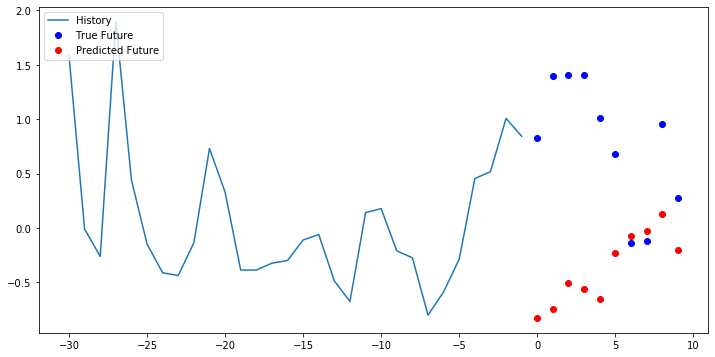

In [59]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])